# Customer Retention Dashboard – Fashion Boutique

## Business Goals
- Analyze customer retention & repeat purchases
- Measure offer redemption effectiveness
- Identify seasonal buying trends
- Quantify financial impact of personalized promotions

## Tools
- Python
- Pandas, NumPy
- Matplotlib, Seaborn, Plotly


In [144]:
!pip install --upgrade nbformat ipython plotly


In [145]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    mean_absolute_error,
    r2_score
)


In [146]:
data_path = "Data.xlsx"
df = pd.read_excel(data_path)

df.head()


,Date,Customer_ID,Purchase_Value,Category,Email_Engagement,Return_Visit,Discount_Used
0,2025-01-12,f7fd1bf5-ad63-447d-ace9-e098b4e09362,185.39,Shoes,Ignored,No,No
1,2024-08-17,f5cb89b6-e71f-45f8-85db-ef7df4158f04,221.27,Jacket,Ignored,No,Yes
2,2024-07-15,7485cd5f-66a4-42b6-abb5-1017b45e9908,162.28,Accessories,Ignored,Yes,Yes
3,2025-04-26,57608169-84d5-421c-99bd-7d57b9d50c43,54.07,Accessories,Ignored,Yes,No
4,2024-09-18,f2b778f1-a4e2-4864-b4fd-bf6c52f151dc,177.58,Accessories,Opened,Yes,No


In [147]:
print(df.columns)
df.info()


Index(['Date', 'Customer_ID', 'Purchase_Value', 'Category', 'Email_Engagement',
       'Return_Visit', 'Discount_Used'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2000 non-null   datetime64[ns]
 1   Customer_ID       2000 non-null   object        
 2   Purchase_Value    2000 non-null   float64       
 3   Category          2000 non-null   object        
 4   Email_Engagement  2000 non-null   object        
 5   Return_Visit      2000 non-null   object        
 6   Discount_Used     2000 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 109.5+ KB


In [148]:
# Convert Date safely
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Robust Yes/No cleaner
def clean_binary(col):
    return (
        col.astype(str)
           .str.strip()
           .str.lower()
           .map({
               'yes': 1, 'no': 0,
               '1': 1, '0': 0,
               'true': 1, 'false': 0
           })
    )

df['Return_Visit_Num'] = clean_binary(df['Return_Visit'])
df['Discount_Used_Num'] = clean_binary(df['Discount_Used'])
df['Email_Engagement_Num'] = clean_binary(df['Email_Engagement'])

# Time features
df['Month'] = df['Date'].dt.to_period('M')
df['Season'] = (df['Date'].dt.month % 12 // 3 + 1).map({
    1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'
})

df.head()


,Date,Customer_ID,Purchase_Value,Category,Email_Engagement,Return_Visit,Discount_Used,Return_Visit_Num,Discount_Used_Num,Email_Engagement_Num,Month,Season
0,2025-01-12,f7fd1bf5-ad63-447d-ace9-e098b4e09362,185.39,Shoes,Ignored,No,No,0,0,NaN,2025-01,Winter
1,2024-08-17,f5cb89b6-e71f-45f8-85db-ef7df4158f04,221.27,Jacket,Ignored,No,Yes,0,1,NaN,2024-08,Summer
2,2024-07-15,7485cd5f-66a4-42b6-abb5-1017b45e9908,162.28,Accessories,Ignored,Yes,Yes,1,1,NaN,2024-07,Summer
3,2025-04-26,57608169-84d5-421c-99bd-7d57b9d50c43,54.07,Accessories,Ignored,Yes,No,1,0,NaN,2025-04,Spring
4,2024-09-18,f2b778f1-a4e2-4864-b4fd-bf6c52f151dc,177.58,Accessories,Opened,Yes,No,1,0,NaN,2024-09,Fall


In [149]:
retention_rate = df['Return_Visit_Num'].mean() * 100
print(f"Customer Retention Rate: {retention_rate:.2f}%")


Customer Retention Rate: 49.60%


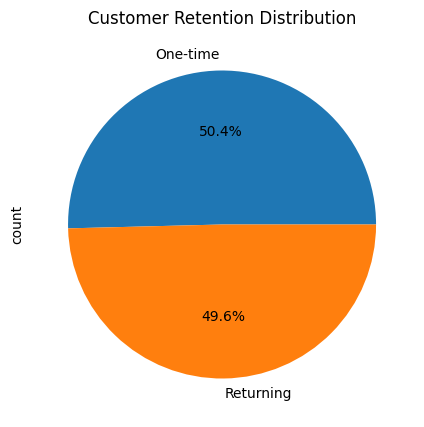

In [150]:
df['Return_Visit_Num'].value_counts().plot(
    kind='pie',
    labels=['One-time', 'Returning'],
    autopct='%1.1f%%',
    figsize=(5,5)
)
plt.title("Customer Retention Distribution")
plt.show()


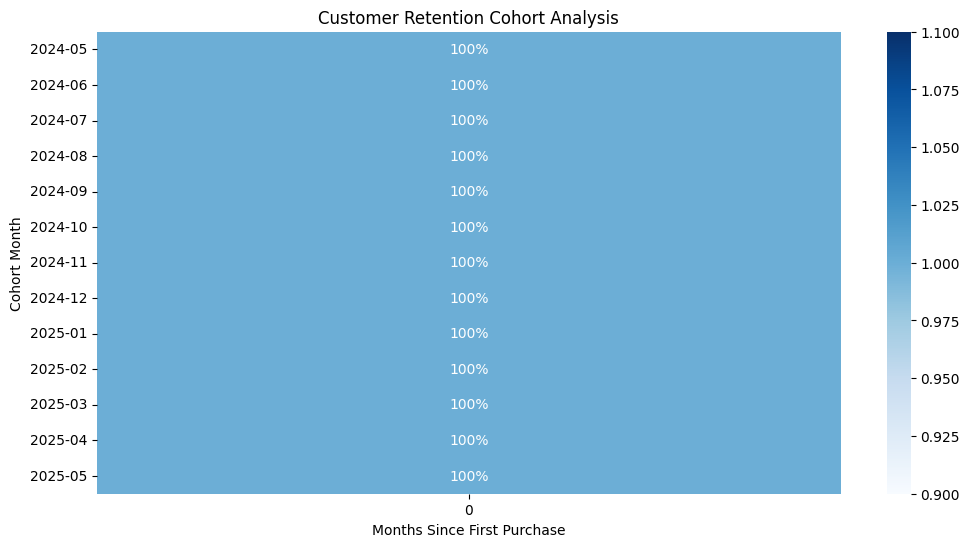

In [151]:
df['Cohort_Month'] = (
    df.groupby('Customer_ID')['Date']
      .transform('min')
      .dt.to_period('M')
)

df['Order_Month'] = df['Date'].dt.to_period('M')
df['Cohort_Index'] = (df['Order_Month'] - df['Cohort_Month']).apply(lambda x: x.n)

cohort = (
    df.groupby(['Cohort_Month', 'Cohort_Index'])['Customer_ID']
      .nunique()
      .reset_index()
)

cohort_pivot = cohort.pivot(
    index='Cohort_Month',
    columns='Cohort_Index',
    values='Customer_ID'
)

retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title("Customer Retention Cohort Analysis")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.show()


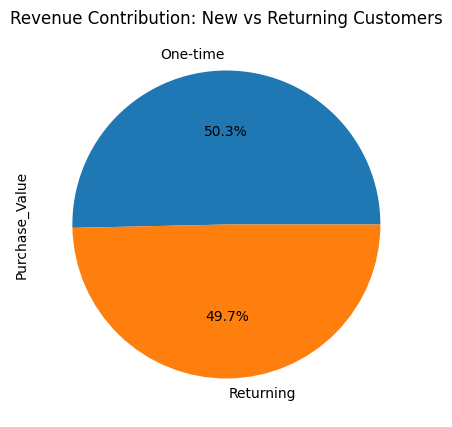

In [152]:
df.groupby('Return_Visit_Num')['Purchase_Value'].sum().plot(
    kind='pie',
    labels=['One-time', 'Returning'],
    autopct='%1.1f%%',
    figsize=(5,5)
)
plt.title("Revenue Contribution: New vs Returning Customers")
plt.show()


In [153]:
promo_roi = df.groupby('Discount_Used_Num').agg(
    Avg_Order_Value=('Purchase_Value', 'mean'),
    Retention_Rate=('Return_Visit_Num', 'mean'),
    Total_Revenue=('Purchase_Value', 'sum')
)

promo_roi


,Avg_Order_Value,Retention_Rate,Total_Revenue
Discount_Used_Num,,,
0,137.115201,0.481891,136292.51
1,134.502913,0.509940,135309.93


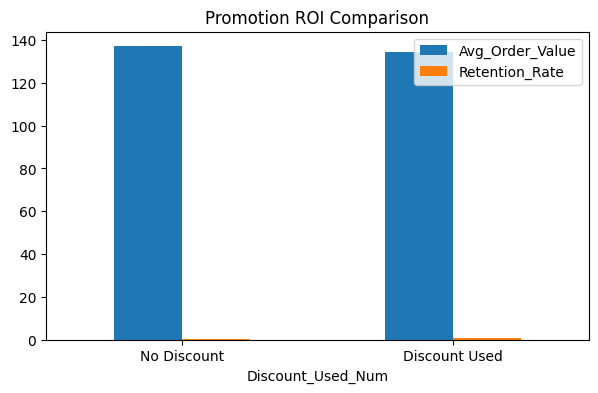

In [154]:
promo_roi[['Avg_Order_Value', 'Retention_Rate']].plot(kind='bar', figsize=(7,4))
plt.xticks([0,1], ['No Discount', 'Discount Used'], rotation=0)
plt.title("Promotion ROI Comparison")
plt.show()


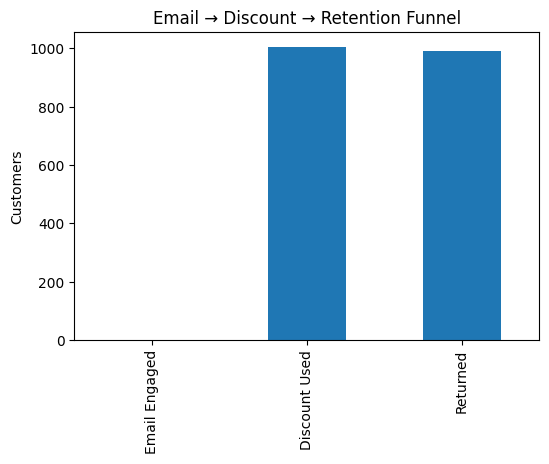

In [155]:
pd.Series({
    'Email Engaged': df['Email_Engagement_Num'].sum(),
    'Discount Used': df['Discount_Used_Num'].sum(),
    'Returned': df['Return_Visit_Num'].sum()
}).plot(kind='bar', figsize=(6,4))

plt.title("Email → Discount → Retention Funnel")
plt.ylabel("Customers")
plt.show()


In [156]:
snapshot_date = df['Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer_ID').agg(
    Recency=('Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Date', 'count'),
    Monetary=('Purchase_Value', 'sum')
)

rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1], duplicates='drop')
rfm['F'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    4, labels=[1,2,3,4], duplicates='drop'
)
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4], duplicates='drop')

rfm[['R','F','M']] = rfm[['R','F','M']].astype(int)
rfm['RFM_Score'] = rfm['R'] + rfm['F'] + rfm['M']

def rfm_segment(score):
    if score >= 10: return 'Champions'
    elif score >= 8: return 'Loyal'
    elif score >= 6: return 'Potential Loyalists'
    elif score >= 4: return 'At Risk'
    else: return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(rfm_segment)
rfm['Segment'].value_counts()


Segment
Loyal                  705
Potential Loyalists    647
Champions              321
At Risk                298
Lost                    29
Name: count, dtype: int64

In [157]:
# Days since last purchase (strong churn signal)
last_purchase = df.groupby('Customer_ID')['Date'].max()
days_since_last = (df['Date'].max() - last_purchase).dt.days

churn_df = df.groupby('Customer_ID').agg(
    Avg_Purchase=('Purchase_Value', 'mean'),
    Orders=('Date', 'count'),
    Email_Engagement=('Email_Engagement_Num', 'mean'),
    Discount_Usage=('Discount_Used_Num', 'mean'),
    Returned=('Return_Visit_Num', 'min')
)

churn_df['Days_Since_Last_Purchase'] = days_since_last
churn_df['Churn'] = (churn_df['Returned'] == 0).astype(int)

X = churn_df.drop(['Churn', 'Returned'], axis=1)
y = churn_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [158]:
churn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', GradientBoostingClassifier())
])

churn_pipeline.fit(X_train, y_train)

y_pred = churn_pipeline.predict(X_test)
y_prob = churn_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.54      0.48      0.51       249
           1       0.53      0.59      0.56       251

    accuracy                           0.53       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.53      0.53      0.53       500

ROC-AUC: 0.5301044816717068


c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.

c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.

c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.



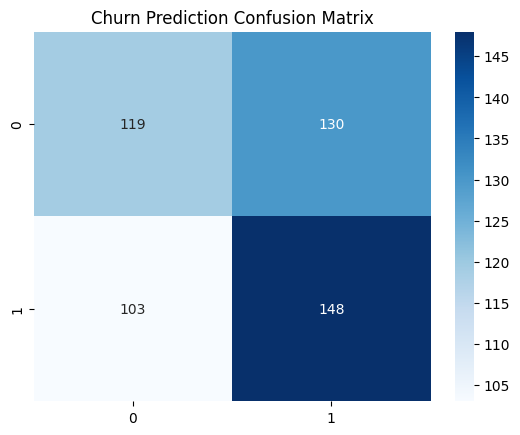

In [159]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Churn Prediction Confusion Matrix")
plt.show()


In [160]:
churn_df['Churn_Probability'] = churn_pipeline.predict_proba(X)[:,1]


c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.



In [161]:
clv_df = df.groupby('Customer_ID').agg(
    Recency=('Date', lambda x: (df['Date'].max() - x.max()).days),
    Frequency=('Date', 'count'),
    Monetary=('Purchase_Value', 'mean'),
    Email_Engagement=('Email_Engagement_Num', 'mean'),
    Discount_Usage=('Discount_Used_Num', 'mean')
)

clv_df['CLV'] = clv_df['Monetary'] * clv_df['Frequency']

X = clv_df.drop('CLV', axis=1)
y = clv_df['CLV']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

clv_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

clv_pipeline.fit(X_train, y_train)

y_pred = clv_pipeline.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

clv_df['Predicted_CLV'] = clv_pipeline.predict(X)


c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.



MAE: 0.07807050000001223
R²: 0.9999975790296076


c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.

c:\Users\Dell\anaconda3\envs\torch_gpu\lib\site-packages\sklearn\impute\_base.py:653: UserWarning:

Skipping features without any observed values: ['Email_Engagement']. At least one non-missing value is needed for imputation with strategy='median'.



In [162]:
rfm_full = rfm.merge(
    churn_df[['Churn_Probability']],
    left_index=True,
    right_index=True
).merge(
    clv_df[['Predicted_CLV']],
    left_index=True,
    right_index=True
)

rfm_full['Priority_Score'] = (
    (rfm_full['Predicted_CLV'] / rfm_full['Predicted_CLV'].max()) *
    rfm_full['Churn_Probability']
)

rfm_full.sort_values('Priority_Score', ascending=False).head(10)


,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment,Churn_Probability,Predicted_CLV,Priority_Score
Customer_ID,,,,,,,,,,,
e0d02862-7def-4e60-bf6d-07e51a54d25b,4,1,249.61,4,4,4,12,Champions,0.929386,249.55145,0.929356
092ba269-924d-4686-964c-c2cdabb7278a,39,1,249.27,4,1,4,9,Loyal,0.908310,249.25470,0.907201
41b5e73d-a2eb-424f-809e-8a096a6afba3,263,1,249.22,2,2,4,8,Loyal,0.899762,249.22095,0.898541
c5320e3f-a710-4fc6-a20b-6514e3e39a20,57,1,249.42,4,4,4,12,Champions,0.889962,249.39675,0.889381
f65641fc-6d69-4c97-b8ab-831268be5dd6,310,1,249.69,1,4,4,9,Loyal,0.883948,249.55950,0.883948
f63da7cf-e95b-4d1e-8244-b369b47910d6,214,1,249.34,2,4,4,10,Champions,0.857478,249.27415,0.856498
32d3ea3a-9323-4a17-b0e4-a1af80015cee,102,1,249.13,3,1,4,8,Loyal,0.852752,249.11825,0.851245
495b8838-3504-4ec0-abb0-fb54a17aa1e5,3,1,236.54,4,2,4,10,Champions,0.887549,236.61470,0.841511
eee1d4ba-519c-47c7-98bb-8f5f3a26ebcd,14,1,245.01,4,4,4,12,Champions,0.856214,245.01560,0.840625


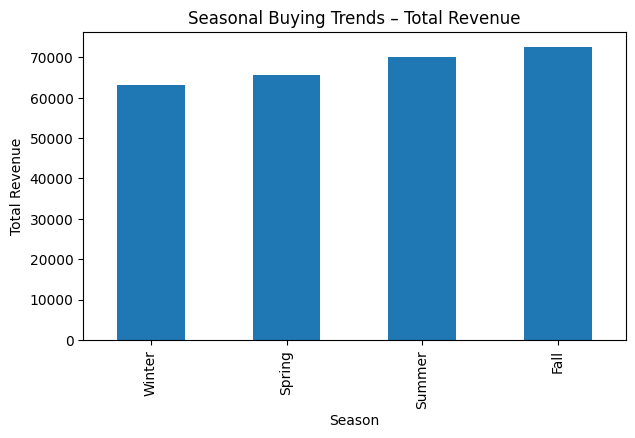

In [164]:
# Aggregate revenue by season
seasonal_revenue = (
    df.groupby('Season')['Purchase_Value']
      .sum()
      .reindex(['Winter', 'Spring', 'Summer', 'Fall'])
)

# Plot
plt.figure(figsize=(7,4))
seasonal_revenue.plot(kind='bar')
plt.title("Seasonal Buying Trends – Total Revenue")
plt.xlabel("Season")
plt.ylabel("Total Revenue")
plt.show()


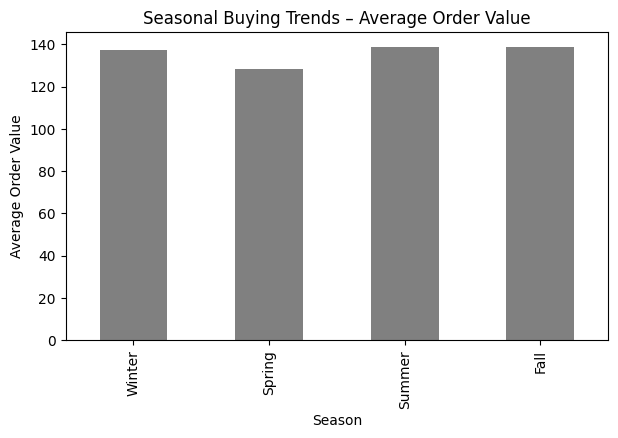

In [165]:
seasonal_aov = (
    df.groupby('Season')['Purchase_Value']
      .mean()
      .reindex(['Winter', 'Spring', 'Summer', 'Fall'])
)

plt.figure(figsize=(7,4))
seasonal_aov.plot(kind='bar', color='gray')
plt.title("Seasonal Buying Trends – Average Order Value")
plt.xlabel("Season")
plt.ylabel("Average Order Value")
plt.show()


## Segment-Specific Action Plan

### 🥇 Champions
• VIP access, exclusivity, loyalty rewards  

### 💎 Loyal
• Personalized recommendations, free shipping  

### 🌱 Potential Loyalists
• Welcome-back offers, email nurturing  

### ⚠ At Risk
• Win-back discounts, urgency messaging  

### ❌ Lost
• Low-cost reactivation campaigns  

**Priority Rule:**  
High Predicted CLV × High Churn Probability = Immediate Action


In [163]:
print("✅ FINAL NOTEBOOK COMPLETE — ROBUST, CLIENT-READY, STARTUP-GRADE")


✅ FINAL NOTEBOOK COMPLETE — ROBUST, CLIENT-READY, STARTUP-GRADE
